In [36]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.python.framework import ops
import math

%matplotlib inline
random_seed = 21

In [15]:
def load_dataset():
    train_dataset = pd.read_csv('data/train.csv')
    X_test_orig = pd.read_csv('data/test.csv')
    
    X_train_orig = train_dataset.drop(labels = ['label'], axis = 1)
    Y_train_orig = train_dataset['label']
    del train_dataset
    
    return X_train_orig, Y_train_orig, X_test_orig

In [16]:
# loading the data
X_train_orig, Y_train_orig, X_test_orig = load_dataset()

In [17]:
X_train = X_train_orig/255
X_test = X_test_orig/255

In [18]:
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

Y_train = np.eye(10)[Y_train_orig.values.reshape(-1)]

del X_train_orig, Y_train_orig, X_test_orig

In [19]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(Y_val.shape))

number of training examples = 37800
number of validation examples = 4200
X_train shape: (37800, 28, 28, 1)
Y_train shape: (37800, 10)
X_val shape: (4200, 28, 28, 1)
Y_val shape: (4200, 10)


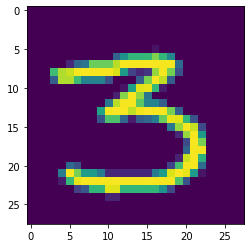

In [20]:
plt.imshow(X_train[4][:,:,0])

In [21]:
conv_layers = {}

In [22]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.placeholder(shape=[None, n_H0, n_W0, n_C0], dtype=tf.float32)
    Y = tf.placeholder(shape=[None, n_y], dtype=tf.float32)
    
    return X, Y

In [29]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Note that we will hard code the shape values in the function to make the grading simpler.
    Normally, functions should take values as inputs rather than hard coding.
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(21)
        
    W1 = tf.get_variable("W1", [4, 4, 1, 8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [40]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Note that for simplicity and grading purposes, we'll hard-code some values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    s = 1
    Z1 = tf.nn.conv2d(X, W1, strides = [1,s,s,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    f = s = 8
    P1 = tf.nn.max_pool(A1, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    s = 1
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,s,s,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    f = s = 4
    P2 = tf.nn.max_pool(A2, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME')
    # FLATTEN
    F2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(F2, 10, activation_fn=None)

    return Z3

In [31]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (number of examples, 6)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    
    return cost

In [51]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [112]:
def model(X_train, Y_train, X_val, Y_val, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_val -- training set, of shape (None, 64, 64, 3)
    Y_val -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the val set (X_val)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                """
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost.
                # The feedict should contain a minibatch for (X,Y).
                """
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)

        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the val set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        val_accuracy = accuracy.eval({X: X_val, Y: Y_val})
        print("Train Accuracy:", train_accuracy)
        print("Val Accuracy:", val_accuracy)
        
        # Calculate Y_test
        result = sess.run([predict_op],feed_dict = {X: X_test})
                
    return train_accuracy, val_accuracy, parameters, result

Cost after epoch 0: 0.552871
Cost after epoch 5: 0.165943
Cost after epoch 10: 0.146668
Cost after epoch 15: 0.142918
Cost after epoch 20: 0.137195
Cost after epoch 25: 0.130854
Cost after epoch 30: 0.130303
Cost after epoch 35: 0.130250
Cost after epoch 40: 0.124166
Cost after epoch 45: 0.125976
Cost after epoch 50: 0.124833
Cost after epoch 55: 0.122066
Cost after epoch 60: 0.118972
Cost after epoch 65: 0.120216
Cost after epoch 70: 0.124280
Cost after epoch 75: 0.117463
Cost after epoch 80: 0.119000
Cost after epoch 85: 0.117869
Cost after epoch 90: 0.115485
Cost after epoch 95: 0.114270


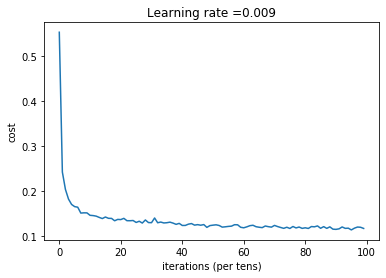

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.964127
Val Accuracy: 0.95619047


In [113]:
_, _, parameters, result = model(X_train, Y_train, X_val, Y_val)

In [116]:
#print(result)
results = pd.Series(result[0], name="Label")
#print(results)

In [117]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_2.csv",index=False)